In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv("../data/processed/final_training_data.csv")

# Quick look
df.head()

# Basic info
df.info()

# Check for nulls
df.isnull().sum()

/var/folders/px/j7p2_nnn6h339lc16xg05qbw0000gn/T/ipykernel_53826/2739705867.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/final_training_data.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528625 entries, 0 to 528624
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   requestid            528625 non-null  int64  
 1   boro                 528625 non-null  object 
 2   year                 528625 non-null  int64  
 3   month                528625 non-null  int64  
 4   day                  528625 non-null  int64  
 5   hour                 528625 non-null  int64  
 6   minute               528625 non-null  int64  
 7   vol                  528625 non-null  int64  
 8   segmentid            528625 non-null  int64  
 9   wktgeom              528625 non-null  object 
 10  street               528625 non-null  object 
 11  fromst               528625 non-null  object 
 12  tost                 528625 non-null  object 
 13  direction            528625 non-null  object 
 14  timestamp            528625 non-null  object 
 15  dayofweek        

requestid                   0
boro                        0
year                        0
month                       0
day                         0
hour                        0
minute                      0
vol                         0
segmentid                   0
wktgeom                     0
street                      0
fromst                      0
tost                        0
direction                   0
timestamp                   0
dayofweek                   0
is_weekend                  0
is_rush_hour                0
is_holiday                  0
holiday_name           510289
holiday_type           510289
is_holiday_period           0
temperature_2m              0
precipitation               0
weathercode                 0
windspeed_10m               0
weather_description         0
dtype: int64

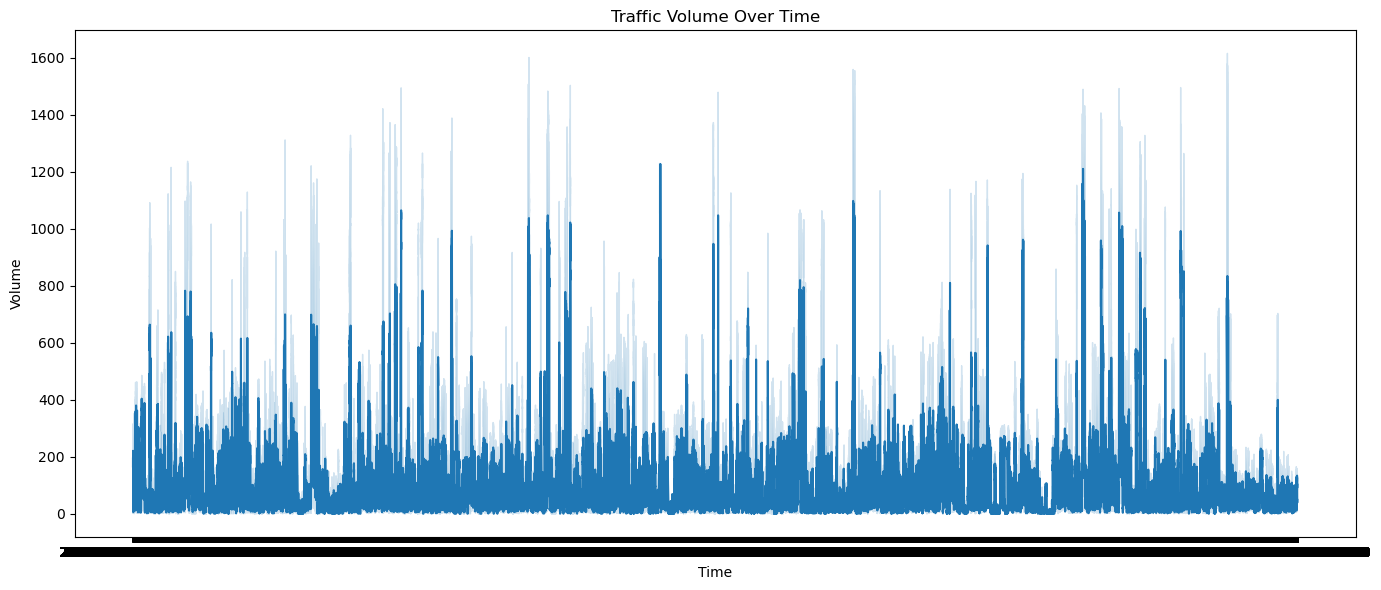

In [20]:
# Line Plot: Volume Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='timestamp', y='vol')
plt.title("Traffic Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

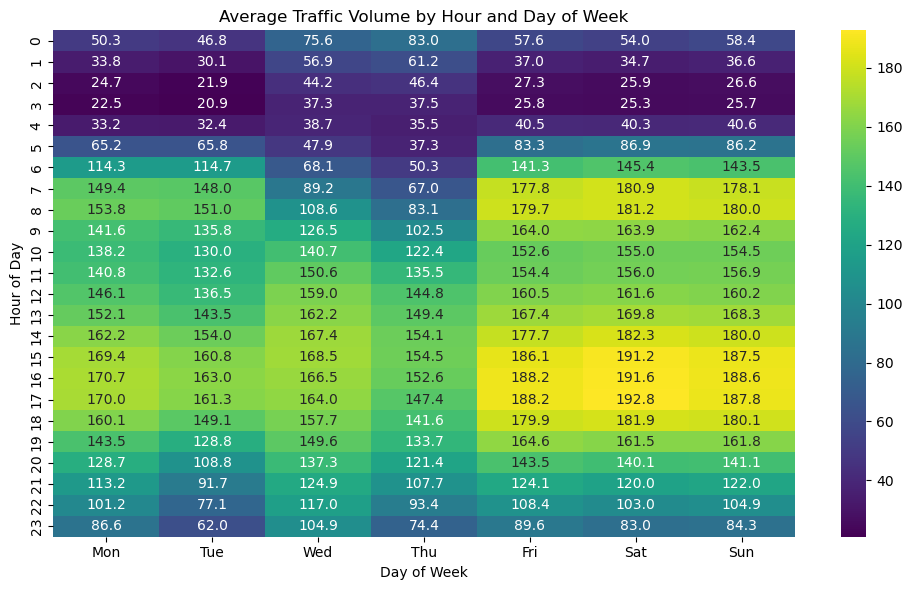

In [22]:
# Heatmap: Hour vs Day of Week

# Pivot table: rows=hour, columns=dayofweek, values=mean volume
pivot = df.pivot_table(index='hour', columns='dayofweek', values='vol', aggfunc='mean')

# Rename columns from 0–6 to weekday names
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title("Average Traffic Volume by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

In [ ]:
# Heatmap by bourough (ex. Manhattan)
manhattan_df = df[df['boro'] == 'Manhattan']

# Then pivot just like before
pivot = manhattan_df.pivot_table(index='hour', columns='dayofweek', values='vol', aggfunc='mean')
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title("Average Traffic Volume in Manhattan by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()